# Целевое кодирование сезонных составляющих в моделировании временных рядов

Геннадий Бут, MSE, Dipl.Ing.

24 декабря 2021 года


## Краткое содержание

В данном ноутбуке предложен подход по моделированию сезонных компонент временных рядов с помощью табличного представления, то есть без попыток разложить такой компонент в ряд Фурье.  Подход позволяет моделировать несколько накладывающихся сезонных колебаний и отличается существенным снижением сложности задачи машинного обучения.  Подход применим для анализа, моделирования и прогнозирования временных рядов. Табличное представление может быть эффективно реализовано с помощью словаря или фрейма данных.



## Введение

Важным направлением исследований в области Data Sciennce в последнее время стало выявление inductive bias. Это априорные знания, допущения, предположения, закладываемые в модель и используемые в ходе решения задачи. Образно замечено, что inductive bias подгоняет под определенные шаблоны наши знания и гипотезы касательно окружающей действительности.  В области задач машинного обучения на временных рядах такие априорные паттерны включают представление об особом характере временных рядов.  Решения из других областей ML проникат в анализ временных рядов очень медленно и с большим трудом.

Одна из концепций связана с особым характером времени. Между тем на практике в качестве реализации абстракции времени используется система из нескольких упорядоченных циклически изменяющихся категорий. Номер дня, недели, месяцв, года - просто некоторые упорядоченные значения из списка. Упорядоченность категории отражает отношение следования одного за другим - 44 календарная неделя будет после 40 недели того же календарного года. В ML задачах эти номера как правило берутся как есть и не очень соответствуют поставленной перед линейной регрессией задаче оптимизации. В ML задачах часто выявляются сезонные колебания - однотипные изменения целевой переменной в пределах одного календарного циклв. Попытка подобрать какое-то более удачное кодирование для сезонного колебания основывается на inductive bias формульной эры - декомпозиции сложного сигнала в набор простых формул, поддающихся оперированию в абстрактном символическом виде.

Второй вредный унаследованный шаблон связан с функциональным анализом. В течение длительного периода времени развитие математики шло по пути использования простых функций, например синусов и косинусов для аппроксимаци колебаний сложной формы. Большие ресурсы тратились на прямое и обратное преобразоваие (разложение в ряд) Фурье и работу с таким рядом. Сегодня вместо представления в виде функции с определенными свойствами (непрерывность и т.д.)  можно использовать ее табличное представление, когда в виде фрейма данных или словаря заданы однозначные соответствия входного аргумента и выходного значения. Именно этот механизм и предлагается использовать в анализе временных рядов.

В  ML задачах определенной популярностью пользуется целевое кодирование категриальных переменных. В рамках этого кодирования число, присваиваемое категориальному значению отражает некую величину, пропорциональную целевому значению. Существует несколько различных алгоритмов целевого кодирования, объединенных в пакете category encoders. В данной работе этот пакет использован не будет - это направление для исследований на будущее. В анализе временных рядов в эконометрике существует аналогичная практика построения периодограмм - графиков сезонного колебания целевой величины. Их можно усреднимть за период наблюдений и получить среднюю периодограмму сезонного колебания целевой величины за наблюдаемый период.  Идея настоящей статьи состоит в том, чтобы использовать усредненную периодограмму за сезон в табличном представлении для целевого кодирования сезонных категориальных признаков. Причем такое табличное представление должно быть нормализовано и центрировано. В дальнейшем это табличное представление поступает на вход алгоритма линейной регрессии и рамках оптимизационной задачи подбирается вес целевым образом закодированного признака.

В качестве демонстрационной основы использован учебный набор данных Tunnel Traffic. Это временной ряд ежедневных наблюдений за количеством автомобилей, проехавших через тунель Baregg в Швейцарии в период с ноября 2003 по ноябрь 2005 года. Данные позаимствованы на kaggle [[https://www.kaggle.com/ryanholbrook/seasonality/data?select=tunnel.csv]].

Обычной практикой для ML задач является использование некоторой метрики качества. В данной статье будет использована распространенная метрика MAPE (средняя абсолютная процентная ошибка), рассчитываемая по формуле:
$$ MAPE=\frac{100}{N}\sum_{i=1}^N \frac{|A_i-F_i|}{|A_i|}  $$


## Общая подготовка данных и параметров среды

In [143]:
# from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

simplefilter("ignore")  # ignore warnings to clean up output cells

In [144]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(12, 5))
plt.rc( "axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10 )
plot_params = dict( color="0.75", style="-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False )

%config InlineBackend.figure_format = 'retina'

В качестве показателей качества используем MAPE:

In [145]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))


После чтения данных во фрейм, я назначаю ему индексом зафиксированный момент времени. Также создается фиктивный признак времени time, отражающий просто количество дней, прошедших с начала наблюдений.

In [148]:
tunnel = pd.read_csv('./input/Kaggle/tunnel.csv', parse_dates=["Day"])
tunnel = tunnel.set_index("Day")
# tunnel = tunnel.to_period()
tunnel['time'] = np.arange(len(tunnel.index))
tunnel.head()

,NumVehicles,time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


Удобство данного набора данных - отстутствие пропусков, которые необходимо было бы заполнить.

В качестве базовой наивной модели используем простую линейную регрессию.

In [149]:
X = tunnel.loc[:, ['time']]  # features
y = tunnel.loc[:, 'NumVehicles']  # target
# Train the model
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

MAPE:0.0902


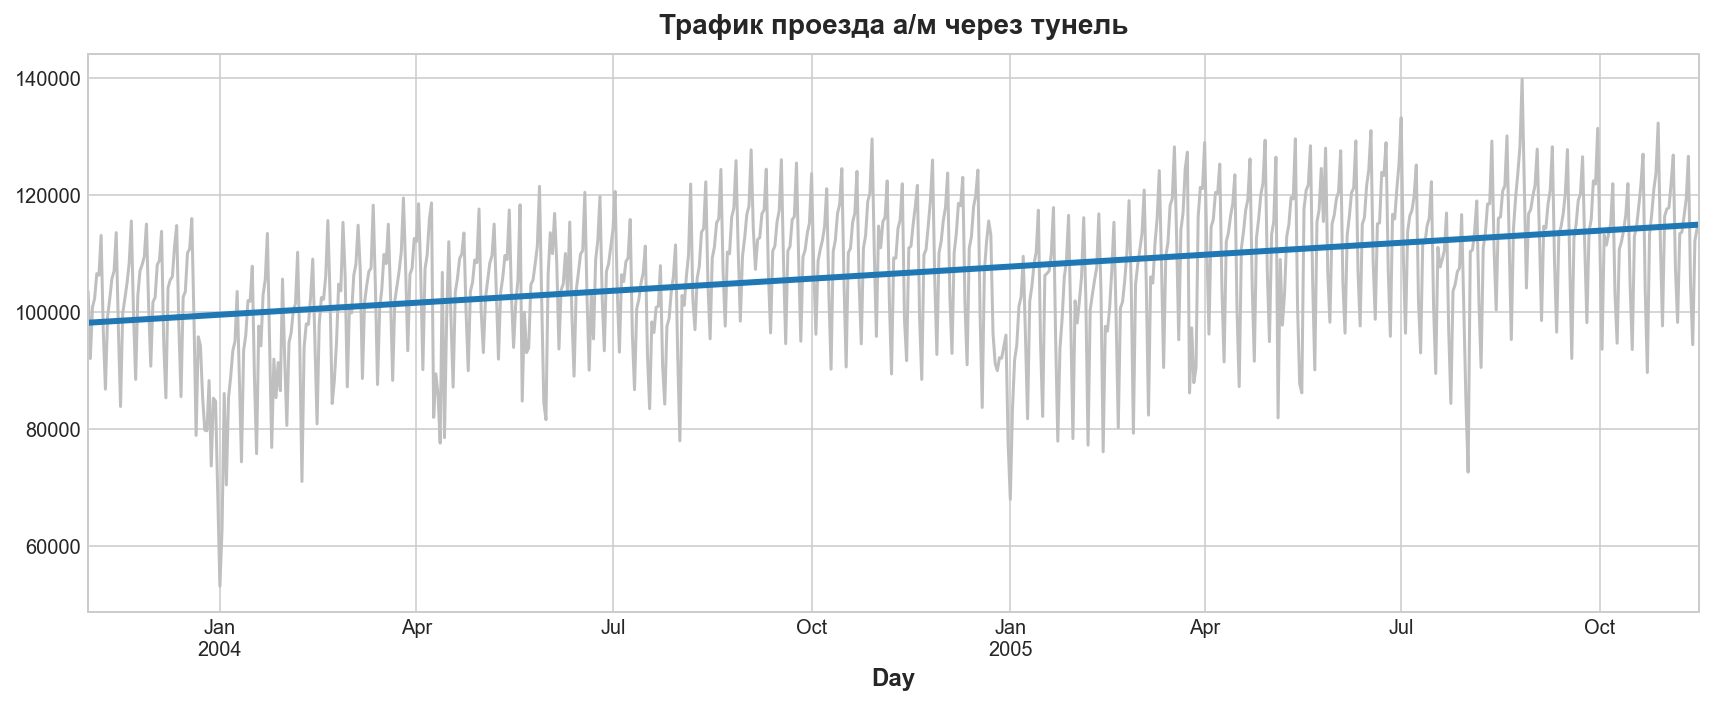

In [151]:
ax = tunnel.NumVehicles.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Трафик проезда а/м через тунель');
print('MAPE:{:.4f}'.format(mape(y,y_pred)))

  Как видим, даже базовая наивная модель обеспечивает неплохую точность аппроксимации.  Цель оставшейся статьи - улучшить это значение.  Также будет важно визуальное соответствие формы.

## Разведочный анализ данных

Используем спектральное разложение для выделения устойчивых временных циклов, используя функцию из библиотеки анализа сигналов. Получающаяся АЧХ позволит выявить наиболее значимые сезонные колебания.


In [155]:
def plot_periodogram(ts, detrend='linear', ax=None, title='Periodogram'):

    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram( ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum', )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    # ax.set_xticklabels( [ "12 мес. (1)", "6 мес. (2)", "3 мес. (4)", "2 мес. (6)", "1 мес. (12)", "2 нед. (26)", "1 нед. (52)", "0.5 нед. (104)"], rotation=30, )
    ax.set_xticklabels( [ "12 мес.", "6 мес.", "3 мес.", "2 мес.", "1 мес.", "2 нед.", "1 нед.", "0.5 нед."] )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(title)
    return ax

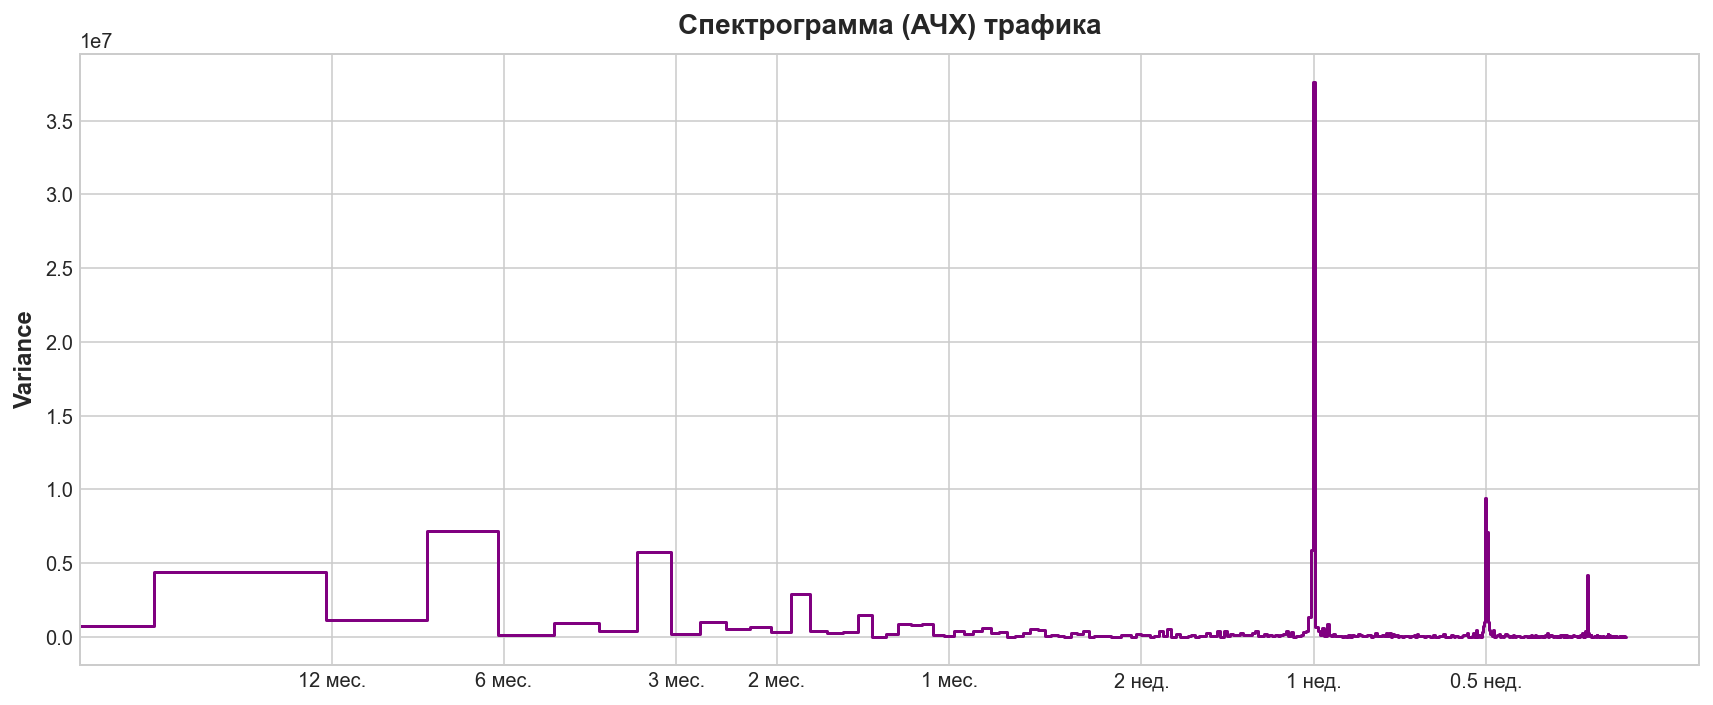

In [156]:
plot_periodogram(tunnel.NumVehicles, title='Спектрограмма (АЧХ) трафика');

На графике видна сильная сезонная компонента с периодом в 1 неделю, и несколько более слабых компонент.
Выделим тренд и сезонность в данных c помощью другого типового решения - seasonal_decompose.

In [157]:
components = seasonal_decompose(tunnel.NumVehicles)

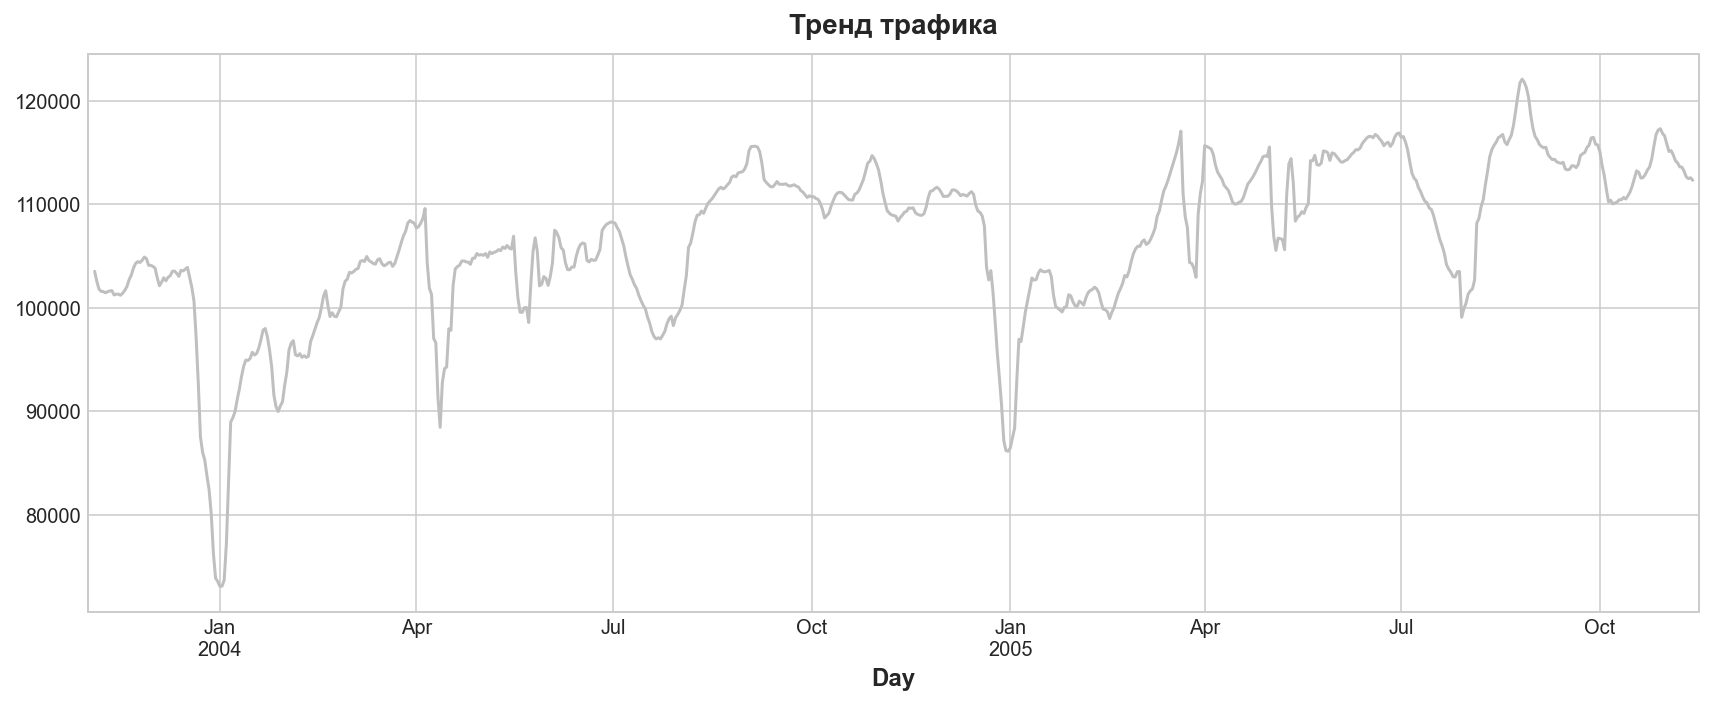

In [158]:
ax = components.trend.plot(**plot_params)
ax.set_title('Тренд трафика');

Тренд на нашем графике выглядит скорее как комбинация тренда и годового сезонного колебания сложной формы.

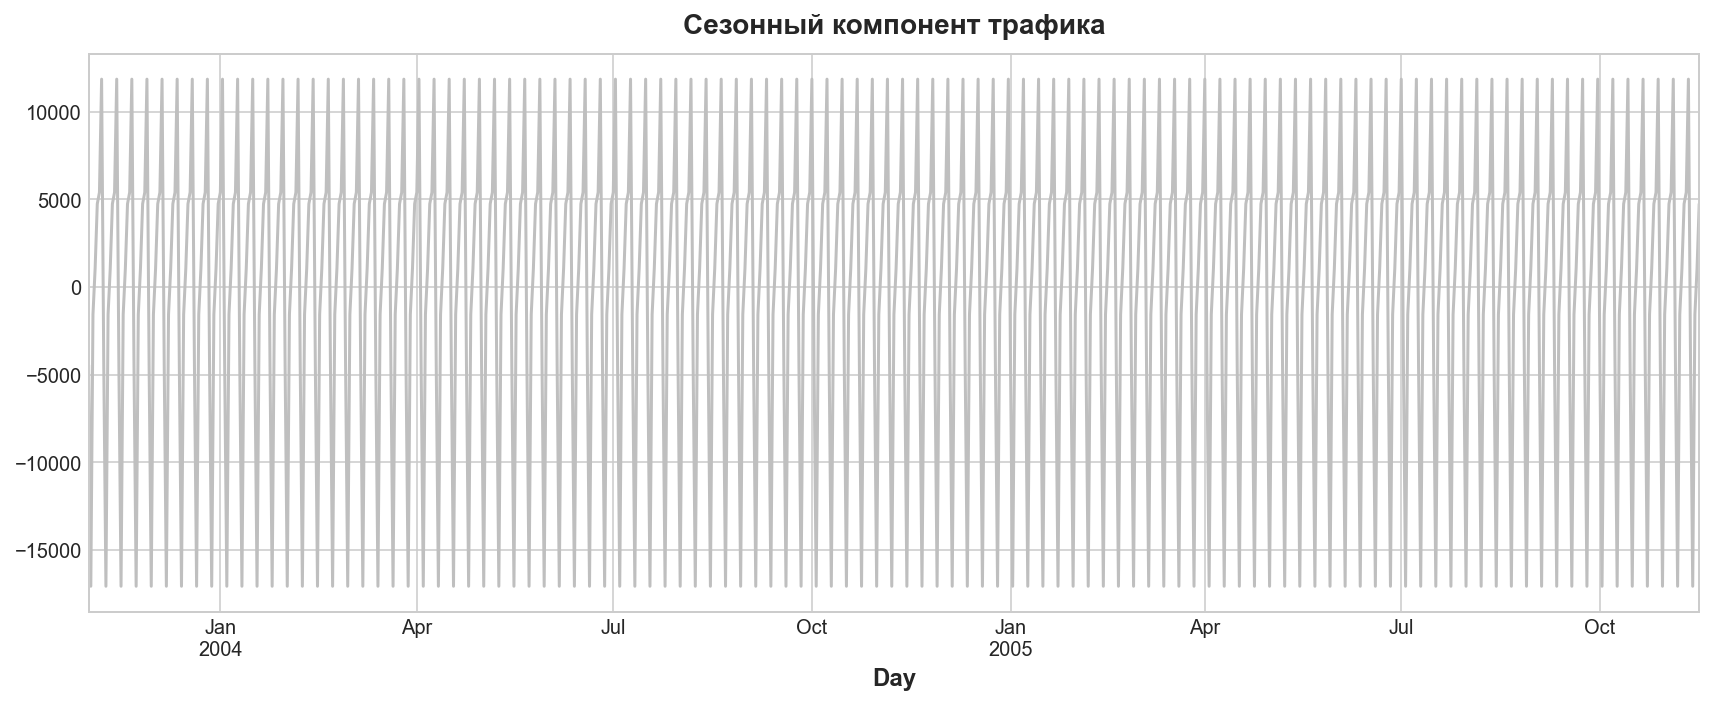

In [159]:
ax = components.seasonal.plot(**plot_params)
ax.set_title('Сезонный компонент трафика');

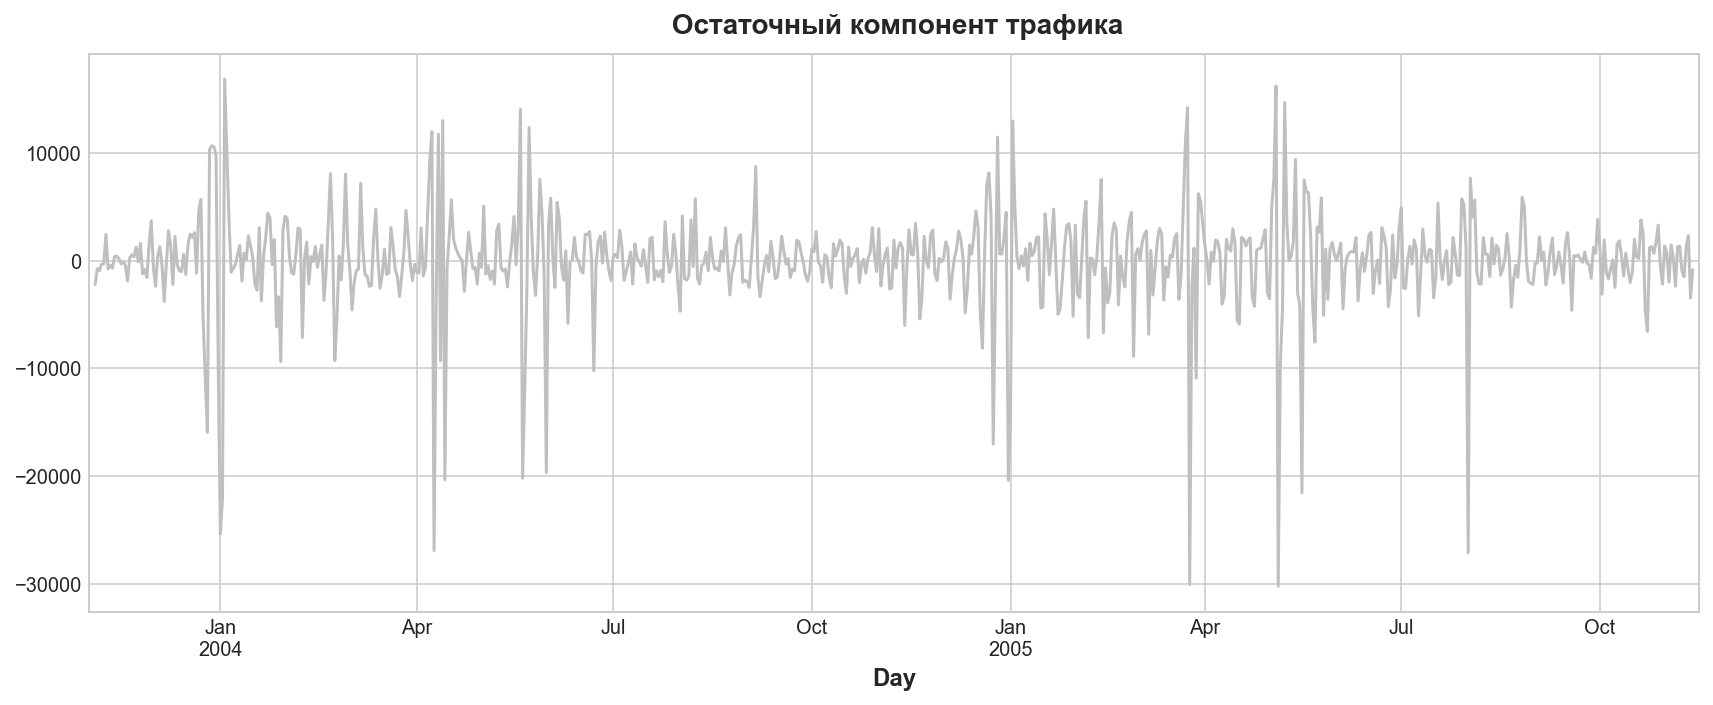

In [160]:
ax = components.resid.plot(**plot_params)
ax.set_title(' Остаточный компонент трафика');

## Построение табличных усредненных периодограмм

По итогам выделения недельного сезонного компонента складывается впечатление, что можно выделить и второй - с периодом около года.  Попробуем преобразовать недельный сезонный компонент в табличную форму.

In [161]:
def estimate_seasonal_trend(data, target_col, index_col, period, normalise=True):
    # period - кортеж из двух чисел - первого и последнего фактических значений категории.
    # target_col - признак целевого значения в наборе data
    # index_col - признак со значениями соответствующей категории в наборе data
    season =  dict()
    for i in range(period[0],period[1]+1):
        season[i] = data.loc[data[index_col]==i][target_col].mean()
    average = sum(season.values())/len(range(period[0],period[1]+1))
    # центрирование периодограммы относительно среднего значения
    for i in range(period[0],period[1]+1):
        season[i] -= average
    if not normalise:
        return season
    # нормализация - максимально отстоящее от центра значение ряда периодограммы приводится к 1
    factor = max( abs( min(season.values())), abs(max(season.values())))
    for i in range(period[0],period[1]+1):
        season[i] = season[i]/factor
    return season

In [137]:
def normalise_seasonal_trend(season, period):
    # period = len(season.keys())
    norm_season = dict()
    factor = max( abs( min(season.values())), abs(max(season.values())))
    # print(factor)
#    mn = min(season.values())
#    mx = max(season.values()) - mn
    for i in range(period[0],period[1]+1):
        # season[i] = (season[i]-mn)/mx
        # print(i, season[i], end=' ')
        norm_season[i] = season[i]/factor
        # print(norm_season[i])
    return norm_season

Формируем категории дня недели и порядкового номера календарной недели.

In [162]:
tunnel['week'] = tunnel.index.week
tunnel["day_week"] = tunnel.index.dayofweek

In [163]:
tunnel.head()

,NumVehicles,time,week,day_week
Day,,,,
2003-11-01,103536,0,44,5
2003-11-02,92051,1,44,6
2003-11-03,100795,2,45,0
2003-11-04,102352,3,45,1
2003-11-05,106569,4,45,2


Сформируем усредненную периодограмму и посмотрим на ее профиль.

In [164]:
weekly_season = estimate_seasonal_trend(tunnel,'NumVehicles','day_week',(0,6), normalise=False)

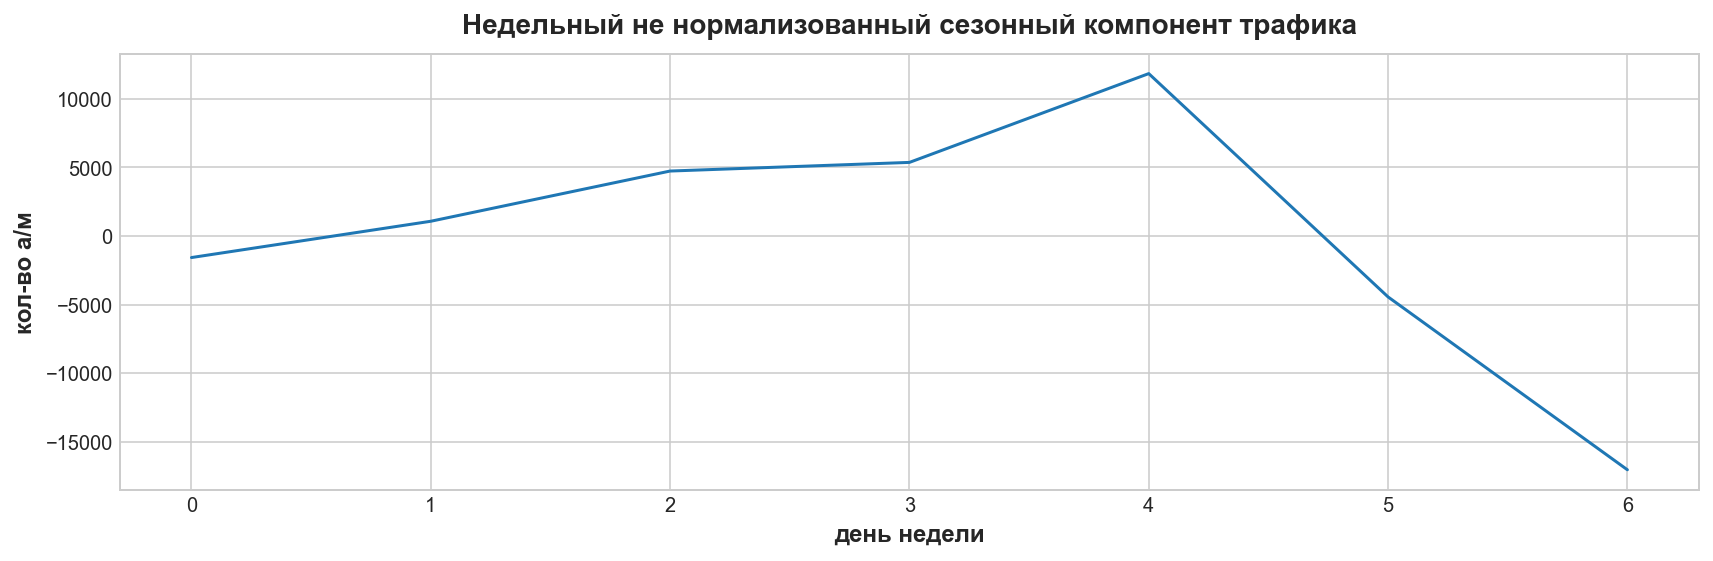

In [167]:
plt.figure(figsize=(12,4))
plt.plot(weekly_season.keys(),weekly_season.values())
plt.xlabel("день недели")
plt.ylabel('кол-во а/м')
plt.title('Недельный не нормализованный сезонный компонент трафика');

Создавая такой график я предполагаю, что в один из дней недели траффик снижается до сезонного (недельного) минимума, потом на следующий день растет скачком до некоторой величины и продолжает рост до сезонного (недельного) максимума с тем, чтобы потом опять снизиться до минимума.

Для целей использования в адитивной модели линейной регрессии необходимо нормализовать это сезонное представление - чтобы максимальное (минимальное) значение было не больше 1.  Для других типов моделей может понадобиться загнать сезонность в другой диапазон, например в диапазон 0..1.


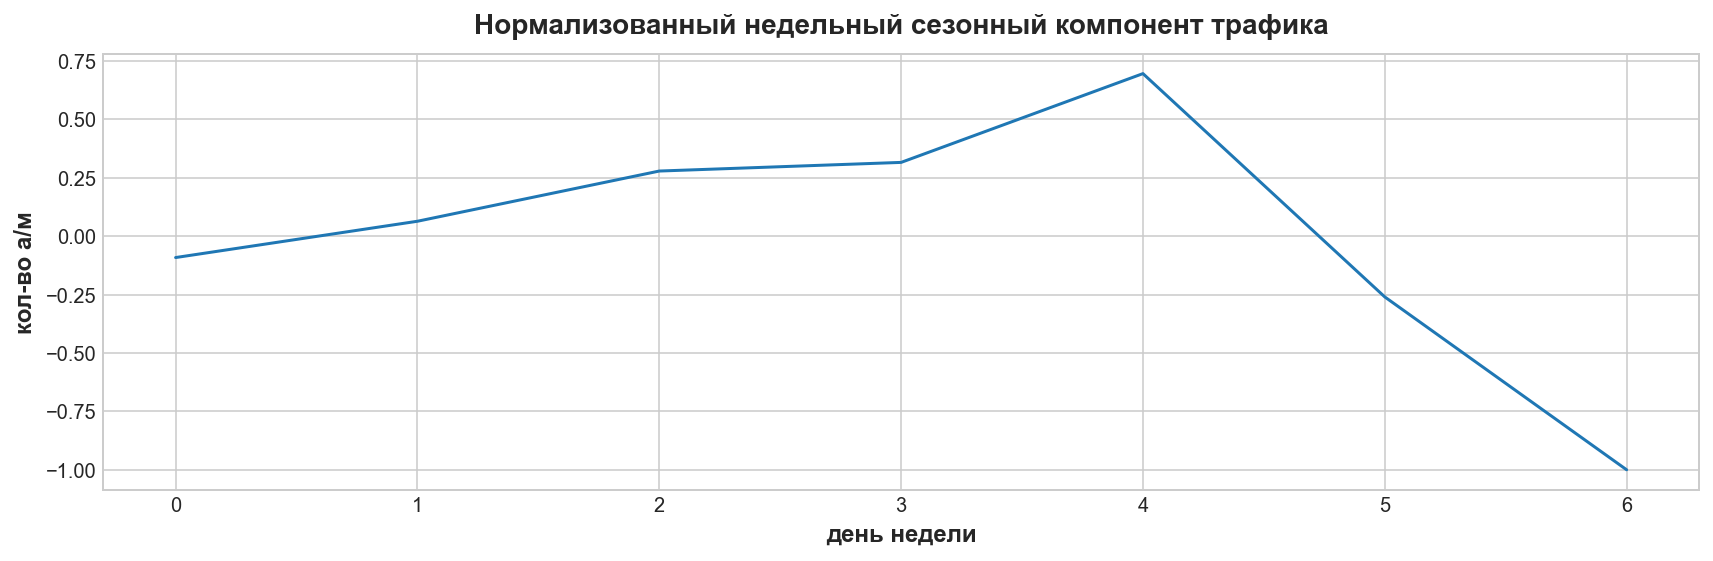

In [168]:
norm_weekly_season =  normalise_seasonal_trend(weekly_season, (0,6))
plt.figure(figsize=(12,4))
plt.plot(norm_weekly_season.keys(),norm_weekly_season.values() )
plt.xlabel("день недели")
plt.ylabel('кол-во а/м')
plt.title('Нормализованный недельный сезонный компонент трафика');


Добавлю такую сезонную компоненту во фрейм данных, а затем попробую построить линейную регрессию на основе компоненты линейного времени и компоненты недельной сезонности.

In [169]:
tunnel['week_season'] = tunnel.day_week.apply(lambda d:weekly_season[d])
tunnel['norm_week_season'] = tunnel.day_week.apply(lambda d:norm_weekly_season[d])

In [170]:
tunnel.head()

,NumVehicles,time,week,day_week,week_season,norm_week_season
Day,,,,,,
2003-11-01,103536,0,44,5,-4434.231176,-0.260382
2003-11-02,92051,1,44,6,-17029.698466,-1.000000
2003-11-03,100795,2,45,0,-1564.576971,-0.091873
2003-11-04,102352,3,45,1,1080.516487,0.063449
2003-11-05,106569,4,45,2,4739.423029,0.278303


Построю еще одну модель линейной регрессии, учитывающую недельную сезонную компоненту.

In [171]:
X = tunnel.loc[:, ['time', 'norm_week_season']]  # features
y = tunnel.loc[:, 'NumVehicles']  # target
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

MAPE:0.0552


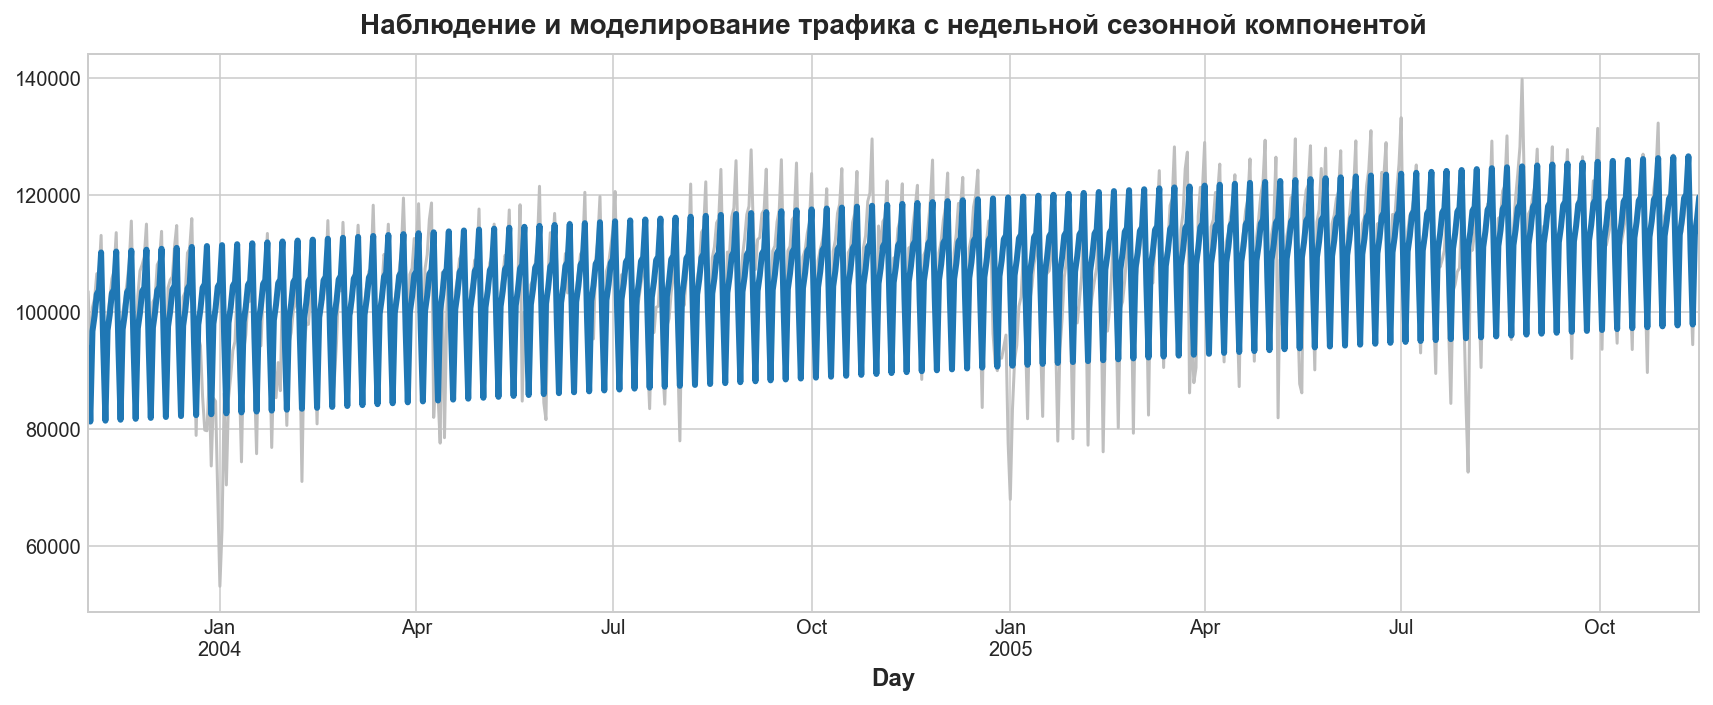

In [172]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Наблюдение и моделирование трафика с недельной сезонной компонентой');
print('MAPE:{:.4f}'.format(mape(y,y_pred)))

Мы видим, что в процессе обучения линейная регрессия растянула выявленную сезонность максимально, чтобы усреднить все выбросы трафика.

Попробую повторить эту операцию и выделить еще один сезонный тренд - годовой. Для визуального анализа годового тренда вычту из наблюдений усредненный центрированный (но не нормализованный) недельный сезонный фактор.

In [173]:
tunnel['nv_less_week_season'] =  tunnel.NumVehicles - tunnel.week_season

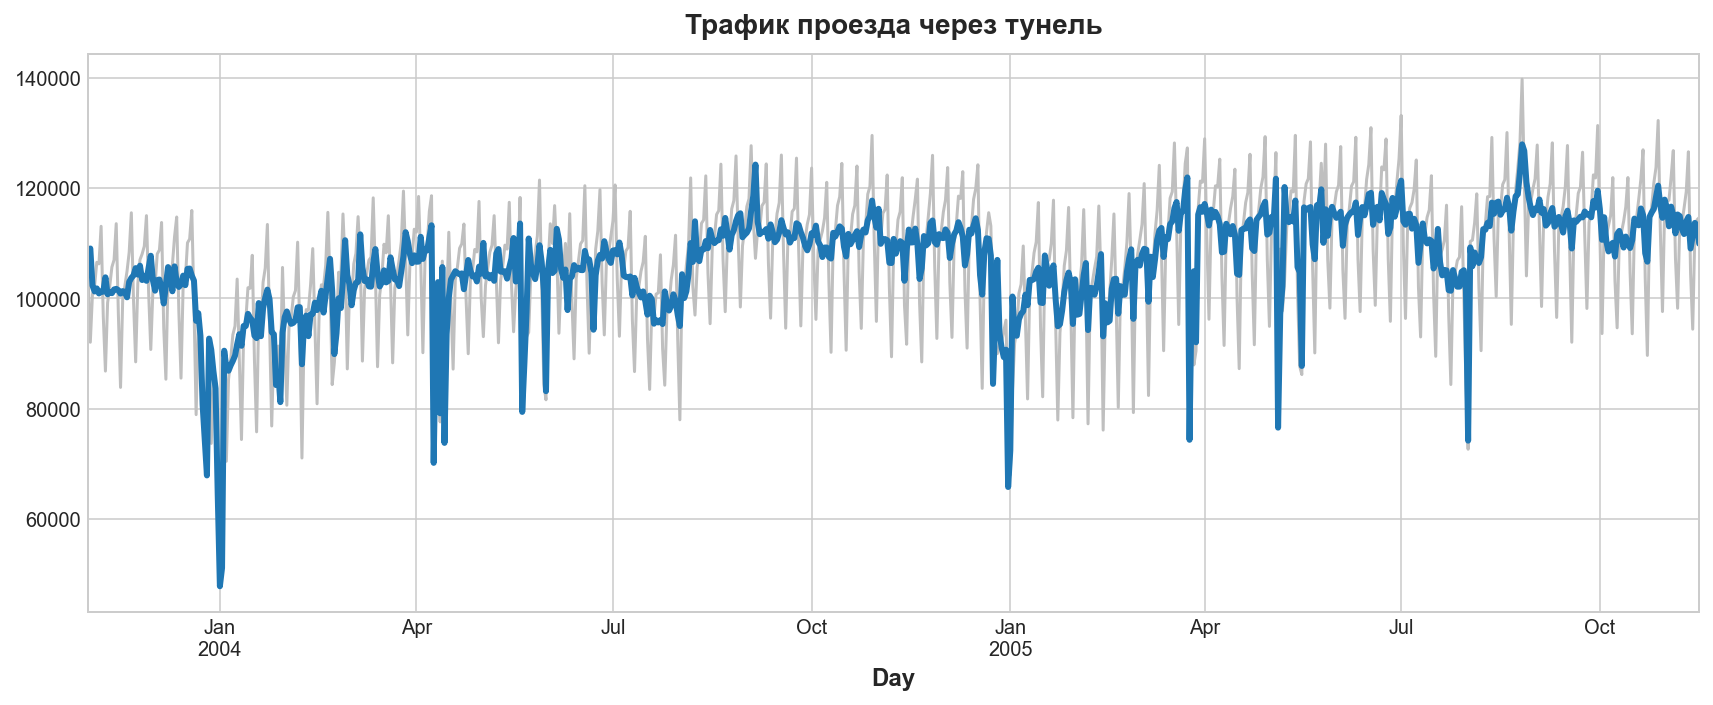

In [174]:
ax = tunnel.NumVehicles.plot(**plot_params)
ax = tunnel.nv_less_week_season.plot(ax=ax, linewidth=3)
ax.set_title('Трафик проезда через тунель');

 На остаточном графике наблюдаются сезонные колебания большой периодичности, а также кратковременные пики, вероятно связанные с календарными и религиозными праздниками - Рождество и т.д.  К сожалению Пасха, и связанные с ней праздники, не имеют фиксированных дат в григорианском каледаре.  Поэтому однозначный годовой сезон будет искажен выбросами таких дней.  Вместо корректировки на религиозные праздники попробую просто сгладить данные.

Можно предложить несколько подходов для сглаживания данных и выявления годового сезонного колебания:
- усреднить остаточные данные (наблюдение минус недельный сезонный фактор) в скользящем окне длительностью 7 или 10 дней, и в этом случае размер сезона будет 365 значений;
- усреднить исходные данные в скользящем окне длительностью 7 или 10 дней;
- усреднить исходные данные в пределах календарной недели (семи дней с одним порядковым номером недели) и в этом случае размер сезона будет 53 значения;
- усреднить исходные данные в пределах календарного месяца и в этом случае размер сезона будет 12 значений.

Попробую сделать сглаживание по календарным неделям.  Сложность этого подхода состоит в том, что у нас есть только один полный года в наборе и два неполных. Преимущество состоит в среднем количестве данных, соответствии уже выявленному недельному тренду и сохранении явной привязке к годовому календарю.

In [175]:
tunnel['year']=tunnel.index.year

In [178]:
# Особенность этого сглаживания - не совсем точный расчет значений в неделях 1 и 53.
# Начало года не совпадает с началом недели и в эти недели будут краевые эффекты.  В дальнейшем эти эффекты частично усреднятся.
weekly_average =  tunnel.groupby(['year','week']).NumVehicles.mean()
tunnel['week_avg'] = tunnel.apply(lambda r: weekly_average[r.year,r.week], axis=1)
# tunnel.head(20)

In [179]:
annual_season = estimate_seasonal_trend(tunnel,'week_avg','week',(1,53), normalise=False)

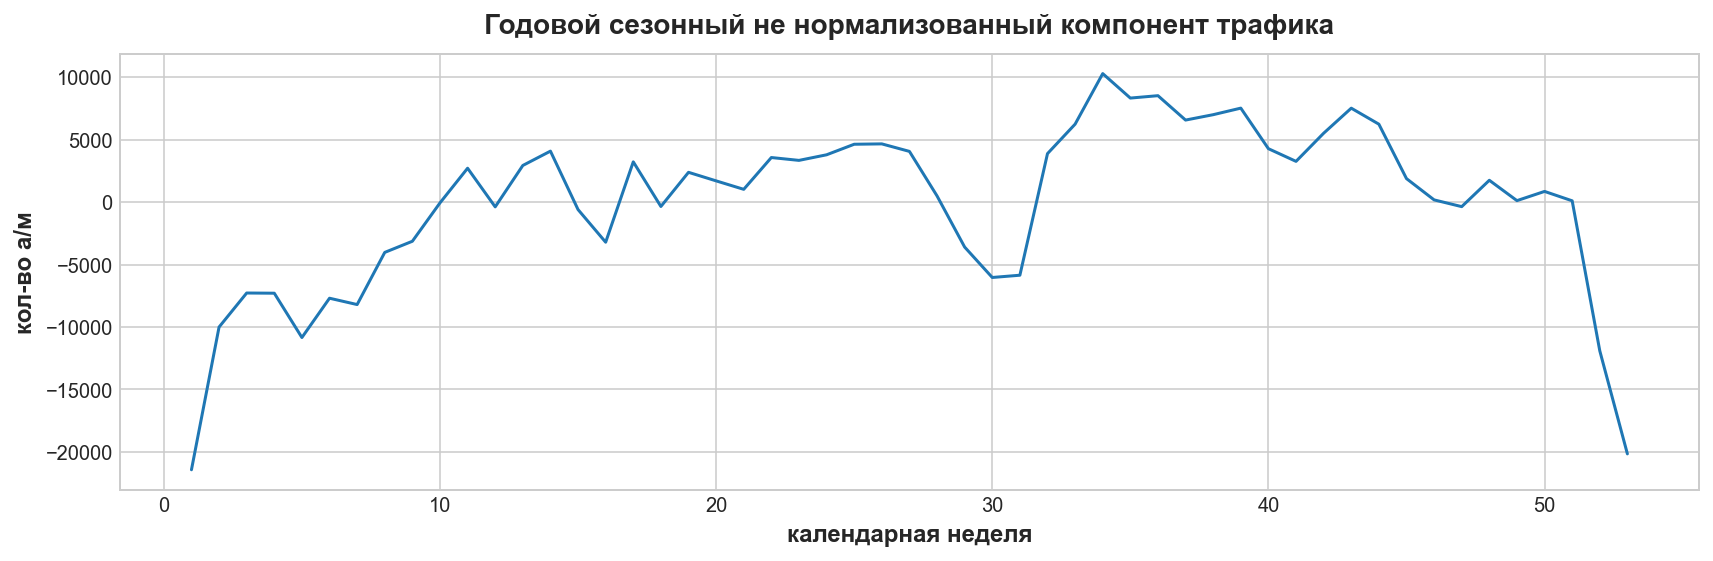

In [181]:
plt.figure(figsize=(12,4))
plt.plot(annual_season.keys(),annual_season.values() )
plt.xlabel("календарная неделя")
plt.ylabel('кол-во а/м')
plt.title('Годовой сезонный не нормализованный компонент трафика');

Такой профиль сезонного колебания было бы наверное очень сложно разложить в ряд Фурье.
Нормализуем его и добавим в качестве признака в фрейм данных.

In [183]:
norm_annual_season =  normalise_seasonal_trend(annual_season, (1,53))

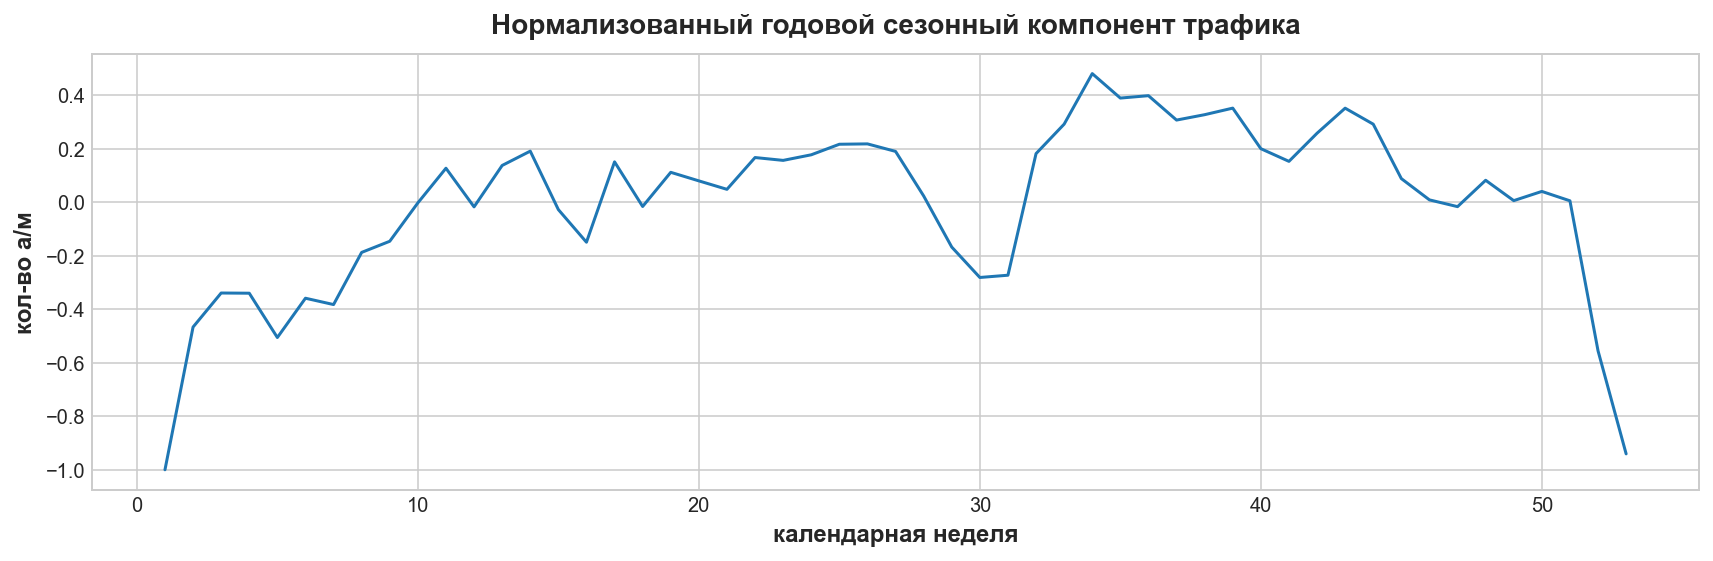

In [184]:
plt.figure(figsize=(12,4))
plt.plot(norm_annual_season.keys(), norm_annual_season.values() )
plt.xlabel("календарная неделя")
plt.ylabel('кол-во а/м')
plt.title('Нормализованный годовой сезонный компонент трафика');

Добавим еще один признак во фрейм данных.

In [185]:
tunnel['annual_season'] = tunnel.week.apply(lambda w: norm_annual_season[w])
# tunnel.head()

Еще раз построим модель линейной регрессии для трафика через тунель с учетом выявленной недельной и годовой сезонности.

In [186]:
X = tunnel.loc[:, ['time', 'norm_week_season', 'annual_season']]  # features
y = tunnel.loc[:, 'NumVehicles']  # target
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

MAPE:0.0364


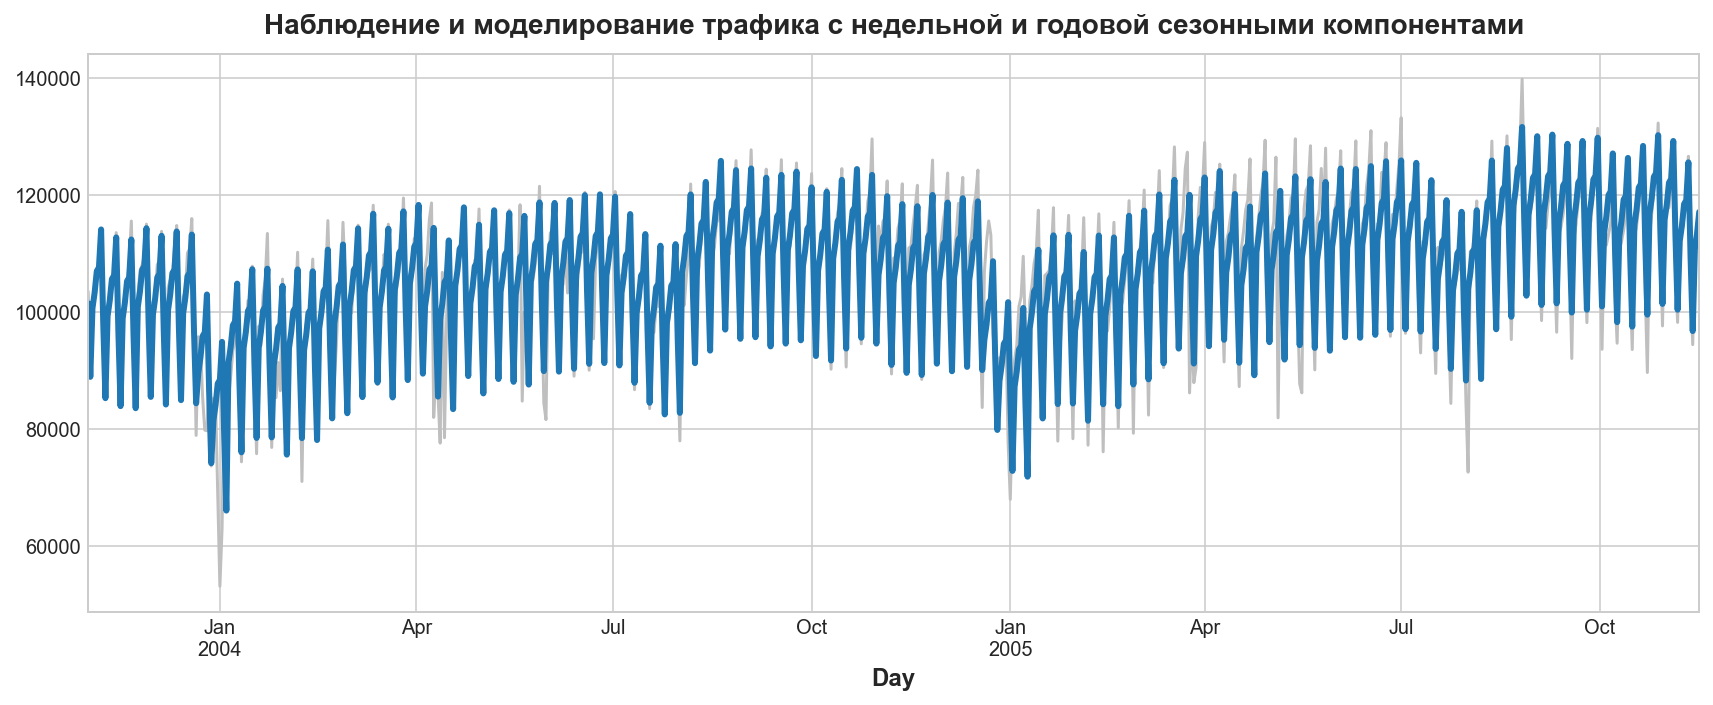

In [187]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Наблюдение и моделирование трафика c недельной и годовой сезонными компонентами');
print('MAPE:{:.4f}'.format(mape(y,y_pred)))

 ## Прогнозирование временного ряда

Для построения прогноза значений временного ряда необходимо сформировать опорную базу в виде набора категориальных признаков - дня с момента наблюдений, целевого сезонного значения недели и целевого сезонного значения дня недели. В случае, если бы был проверочный набор данных - там было бы необходимо сформировать те же признаки.

In [211]:
def prepare_next(df, week_season, ann_season, per_len=90):
    start_date = df.index.max() + pd.DateOffset(days=1)
    start_time = df.time.max() + 1
    next_df = pd.DataFrame(pd.date_range(start_date, periods=per_len, freq='D'),columns=['Day'])
    next_df = next_df.set_index('Day')
    next_df['time'] = np.arange(len(next_df.index)) + start_time
    next_df['week'] = next_df.index.week
    next_df['day_week'] = next_df.index.dayofweek
    next_df['norm_week_season'] = next_df.day_week.apply(lambda d:week_season[d])
    next_df['annual_season'] = next_df.week.apply(lambda w: ann_season[w])
    return next_df.drop(['week','day_week'],axis=1)

Подготовка основы для прогноза вынесена в отдельную функцию.

In [212]:
X_fore = prepare_next(tunnel,norm_weekly_season,norm_annual_season,per_len=90)
X_fore.head()

,time,norm_week_season,annual_season
Day,,,
2005-11-17,747,0.315291,0.008119
2005-11-18,748,0.695212,0.008119
2005-11-19,749,-0.260382,0.008119
2005-11-20,750,-1.000000,0.008119
2005-11-21,751,-0.091873,-0.017131


In [213]:
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

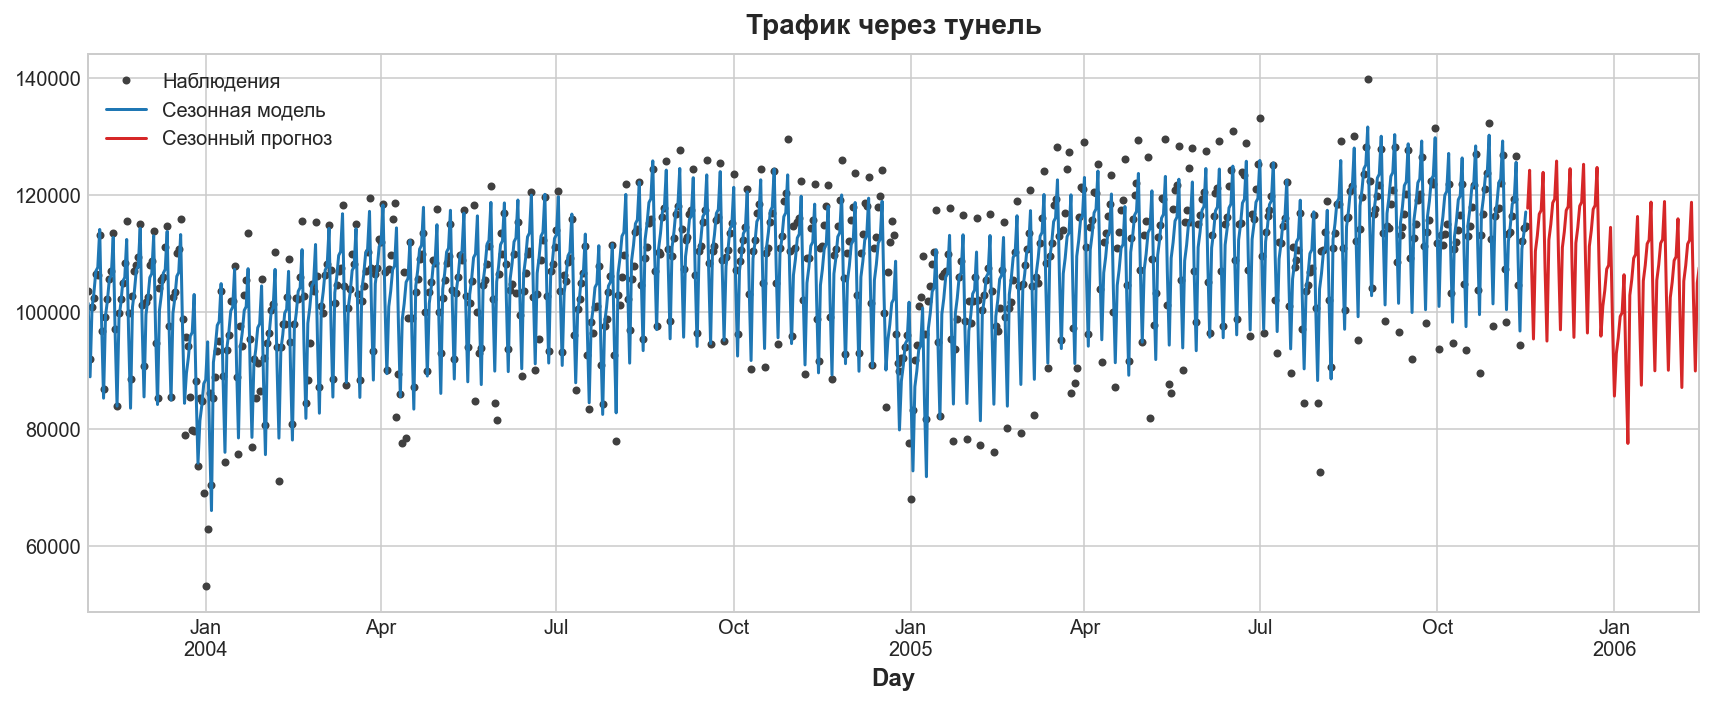

In [215]:
ax = y.plot(color='0.25', style='.', label="Наблюдения", title='Трафик через тунель')
ax = y_pred.plot(ax=ax, label="Сезонная модель")
ax = y_fore.plot(ax=ax, label="Сезонный прогноз", color='C3')
# ax = ax.set_title('Трафик через тунель');
_ = ax.legend()

Если посмотреть на график - модель хорошо аппроксимирует центральную тенденцию трафика. Однако верхние и нижние значения недельного колебания часто остаются недооцененными.  Интересно посмотреть на график распределения модельной ошибки.

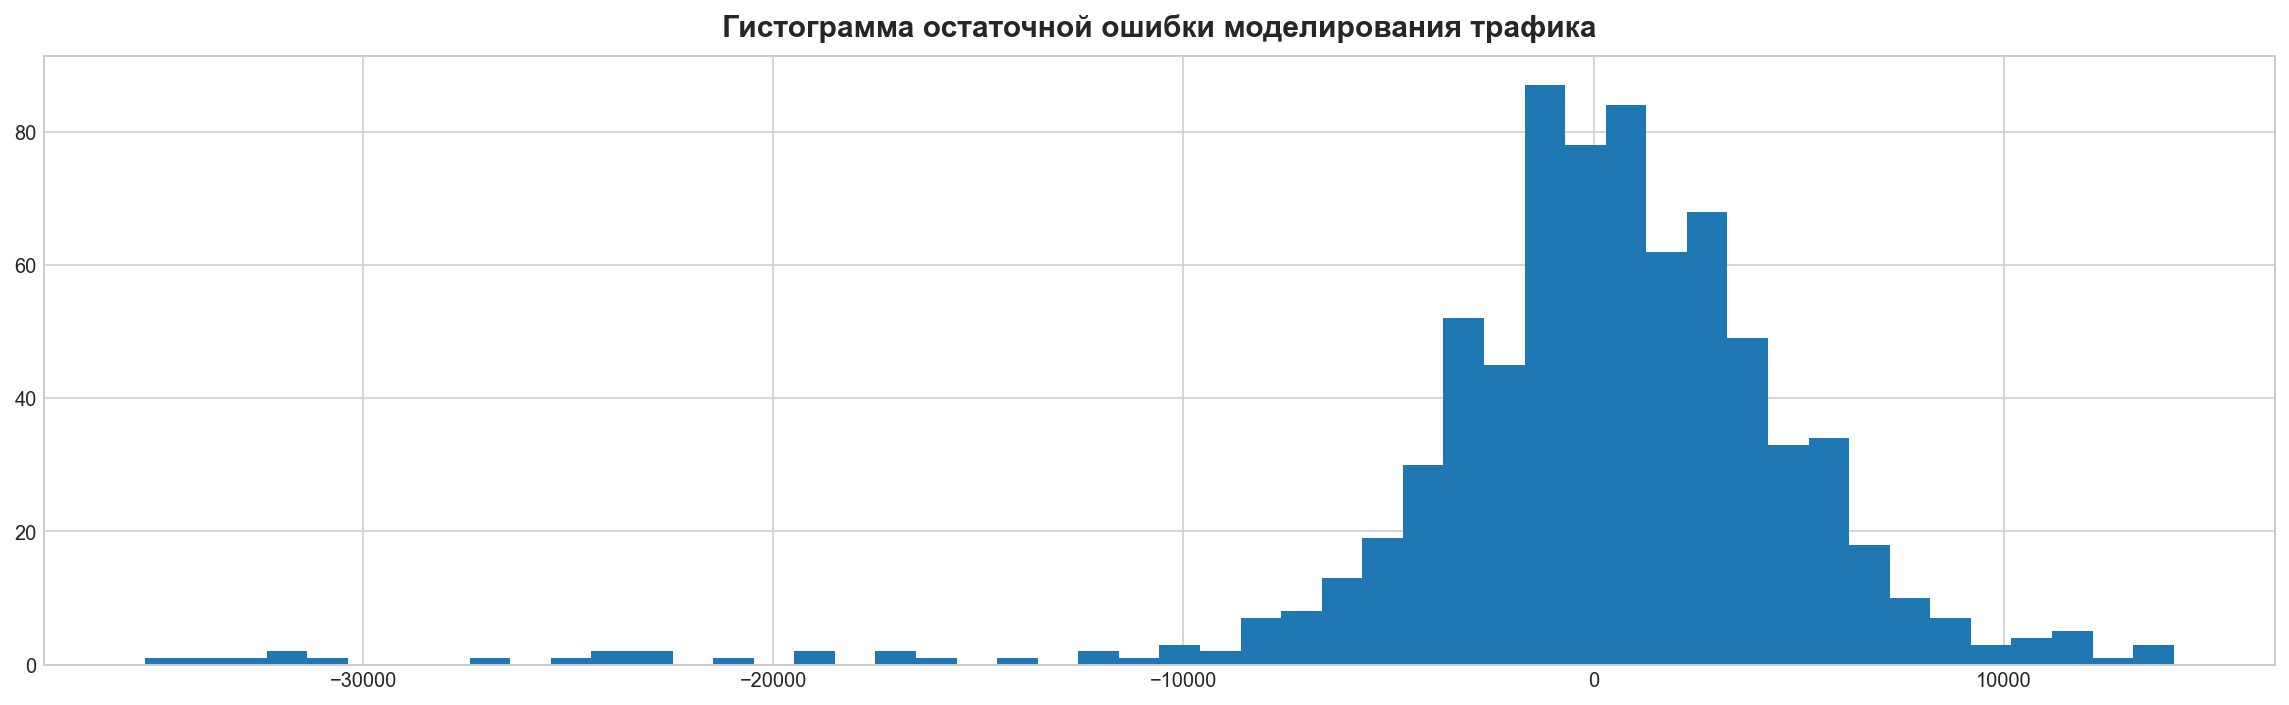

In [239]:
err =  y - y_pred
# plt.figure(figsize=(10,3))
# plt.boxplot(err, vert=False)
# plt.title('Остаточная ошибка моделирования трафика');
plt.figure(figsize=(16, 5))
plt.hist(err, bins=50)
plt.title('Гистограмма остаточной ошибки моделирования трафика', fontsize =15)
plt.show();

В распределении остаточной ошибки тяжелые хвосты. Модель часто и порой существенно переоценивает трафик.  Это может быть связано и с особенностями исходного распределения, и с особенностями выбранного алгоритма линейной регрессии. Такая ошибка может быыть существенной в случае риск-менеджмента, когда основное внимание сосредоточено на неблагоприятных выбросах в ту или иную сторону от центральной тенденции.

Возникают следующие идеи возможнх способов борьбы с ошибками предсказания:
- попробовать моделировать не сам траффик, а его натуральный логарифм,
- поробовать подобрать гиперпараметры алгоритма линейной регрессии,
- попробовать реализовать адаптивное динамическое целевое кодирование признаков (величина целевым образом закодированного признака может меняться в зависимости от другой модели, обученой имитировать динамику этого признака),
- попробовать использовать другой тип модели регрессии.

Модели на основе решающих деревьев (например случаый лес) в простом применении не умеют моделировать рост целевой переменной. Однако такие модели могут работать с первой производной целевой переменной (приростом в текущем временном наблюдении по сравнению с предыдущим). Можно построить и обучить моделировать первую производную (разность) временного ряда, а затем возвращать к нормальному виду с помощью интегрирования (кумулятивного накопления результата). Этому вопросу можно посвятить отдельное исследование.

Еще один вопрос связан с возможностью переобучения. Существует предубеждение, что целевое кодирование склонно к переобучению. Мой опыт показывает, что существующие алгоритмы можно эффективно использовать для повышения качества обычной регрессии. Использование большего по размеру набора данных позволит в следующем исследовании изучить вопрос склонности к переобучению. Пока необходимо отметить, что в предлагаемом подходе используется усреднение, само по себе являющееся эффективным средством борьбы с переобучением.

 В завершении этого материала я хочу посмотреть на поведение еще одного алгоритма регрессии - квантильной регрессии.  В отличие от линейной регрессии она обучается моделировать какую-то квантиль исходных данных, и это может быть полезно для прогнозирования риск-характеристик временных рядов.

## Квантильное моделирование временного ряда



Для квантильного моделирования воспользуюсь относительно новой моделью QuantileRegressor из пакета scikit-learn.

In [224]:
from sklearn.linear_model import QuantileRegressor

Для начала попробую простую линейную модель квантильной регрессии.

In [231]:
X = tunnel.loc[:, ['time']]  # features , 'norm_week_season'
y = tunnel.loc[:, 'NumVehicles']
quantiles = [0.05, 0.5, 0.95]
predictions = {}
for q in quantiles:
    qr = QuantileRegressor(quantile=q, alpha=0)
    predictions[q] = pd.Series(qr.fit(X, y).predict(X), index=X.index)

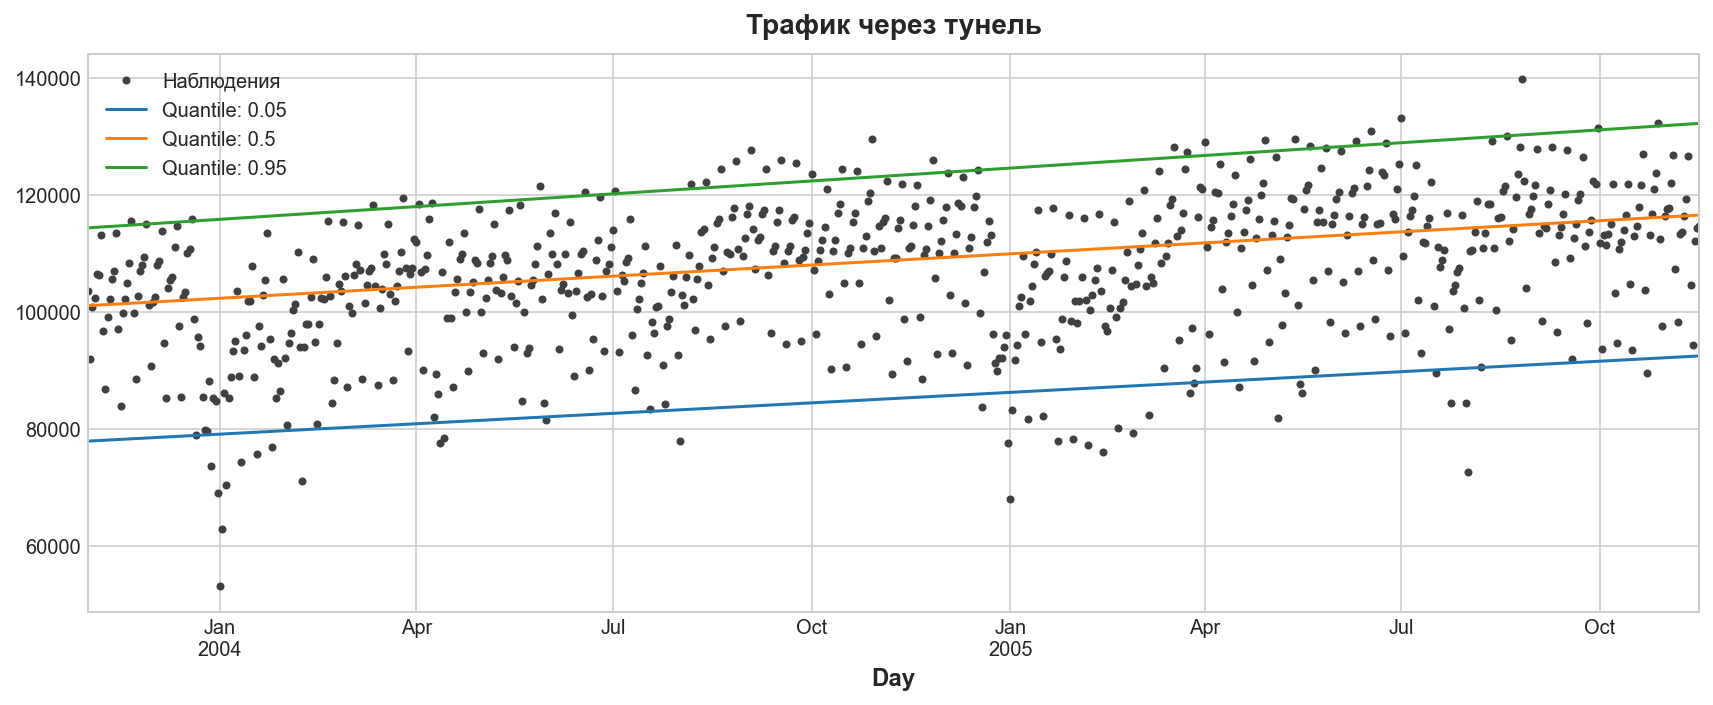

In [232]:
ax = y.plot(color='0.25', style='.', label="Наблюдения", title='Трафик через тунель')
for q, yp in predictions.items():
    ax = yp.plot( ax=ax, label=f"Quantile: {q}")
_ = ax.legend()

На графике видна несимметричность распределения движения а/м через тунель.
Попробую смоделировать трафик с использованием ранее выделенной годовой сезонности.

In [233]:
X = tunnel.loc[:, ['time', 'annual_season']]  # features , 'norm_week_season'
y = tunnel.loc[:, 'NumVehicles']
quantiles = [0.05, 0.5, 0.95]
predictions = {}
for q in quantiles:
    qr = QuantileRegressor(quantile=q, alpha=0)
    predictions[q] = pd.Series(qr.fit(X, y).predict(X), index=X.index)

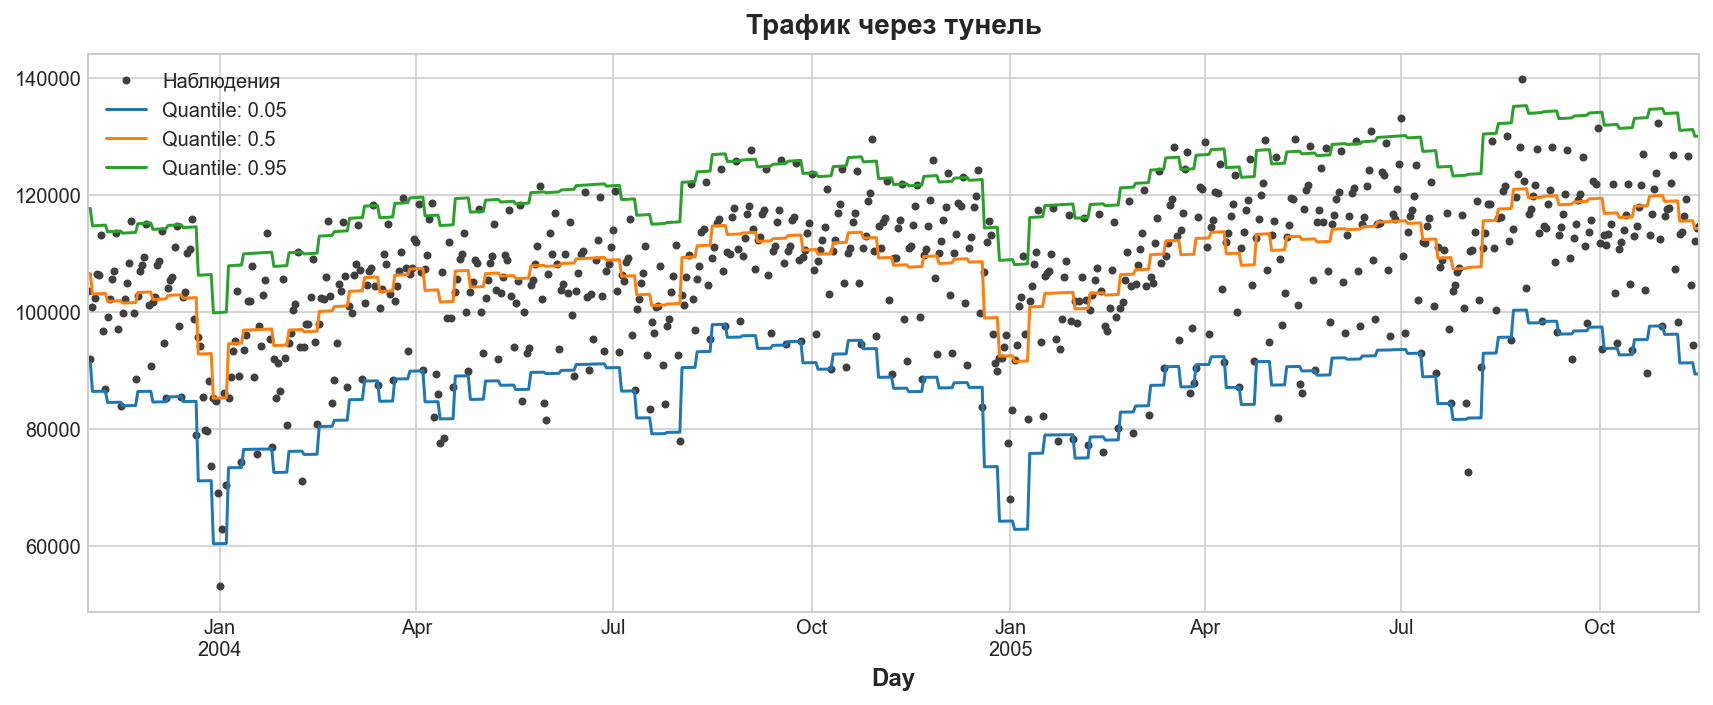

In [234]:
ax = y.plot(color='0.25', style='.', label="Наблюдения", title='Трафик через тунель')
for q, yp in predictions.items():
    ax = yp.plot( ax=ax, label=f"Quantile: {q}")
_ = ax.legend()

В графиках квантильного моделирования вызывает интерес кусочно-линейный характер зависимости. Это связано с тем, что регрессия опирается на признак годовой сезонности, который имеет характер прямой линии в пределах календарной недели. Модель же в намках недели предсказывает возрастающий тренд.
Думаю, что для целей предсказания в рамках риск-менеджмента такой зависимости достаточно. Риск-менеджмент обычно оперирует характеристиками в рамках некоторого временного горизонта.

Еще одно важное наблюдение касается сложности, в том числе вычислительной сложности модели. Квантильная регрессия относится к числу довольно медленных ML алгоритмов, так как требует расчета статистик на каждом шаге обучения. В данном случае параметров, влияющих на результат, всего три - константа и два коэффициента при параметрах времени и годового сезонного колебания.  В случае моделирования с разложением в ряд Фурье для моделирования каждого сезонного компонента на практие может использоваться до 10 пар синус+косинус, что делает время обучения все более длительным6 а сходимосит результата - все более рискованной.

 ## Анализ распределения временного ряда

Форма распределения временного ряда представляет интерес для аналитика, однако она бывает скрыта за временным трендом.  Представляется возможным для анализа использовать не сами наблюдения, а их образ, центрированный относительно медианы с помощью моделирования медианы.

In [235]:
centered_traffic = y - predictions[0.5]

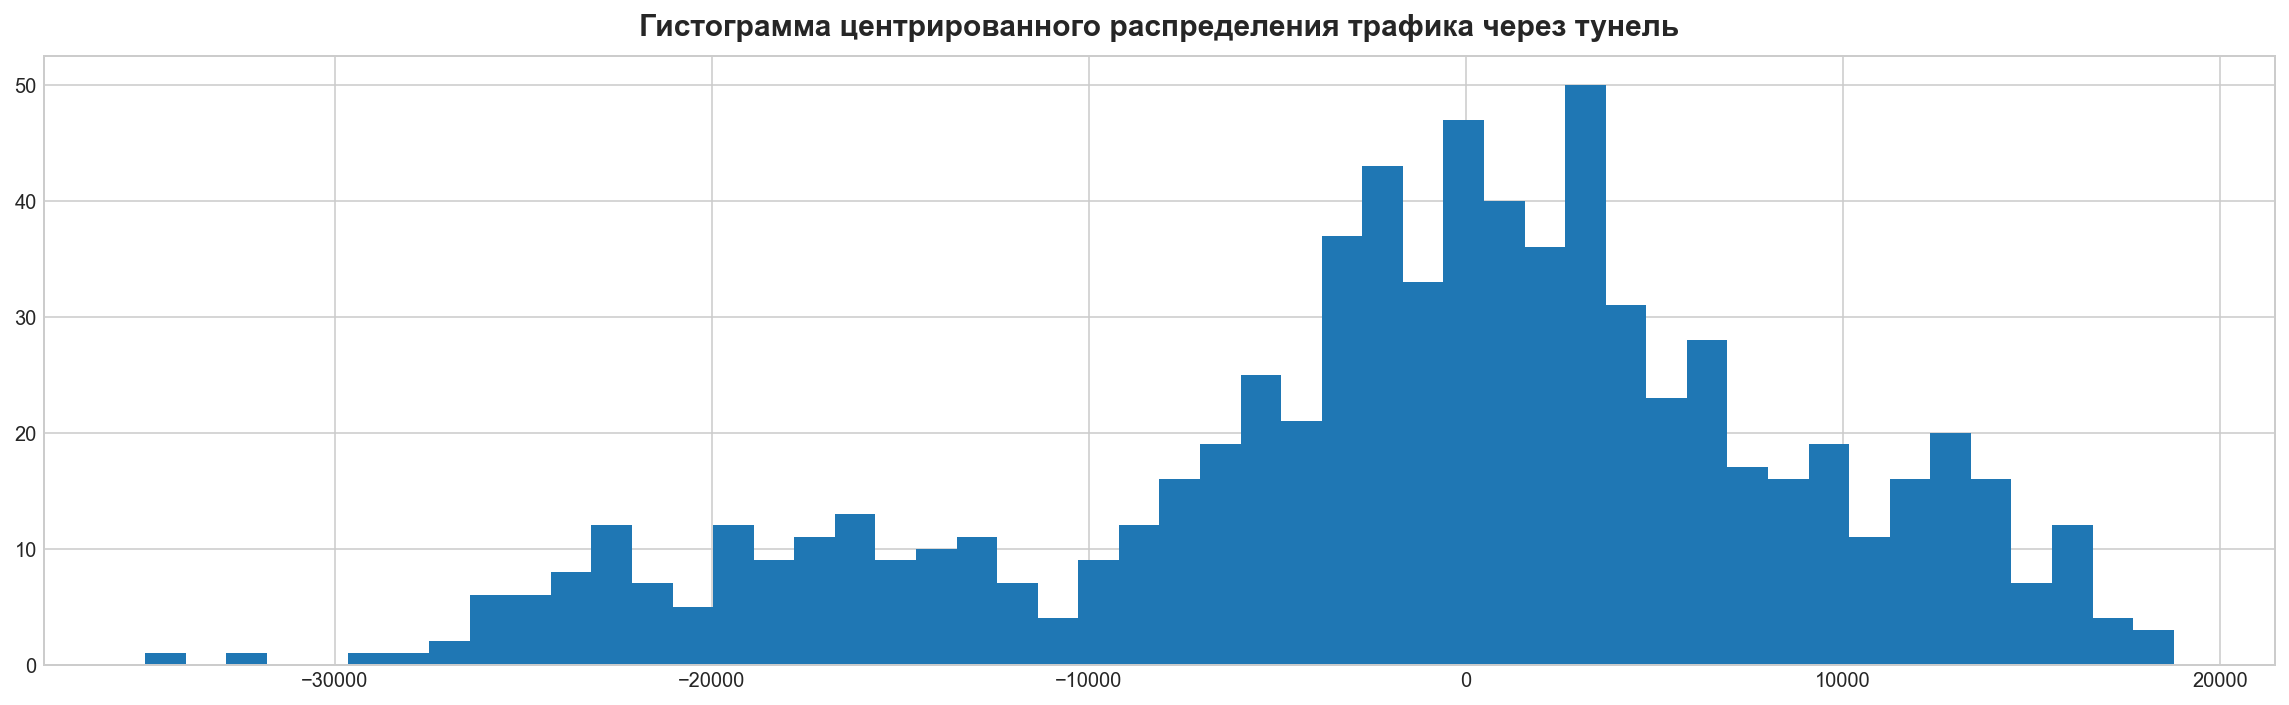

In [237]:
plt.figure(figsize=(16, 5))
plt.hist(centered_traffic, bins=50)
plt.title('Гистограмма центрированного распределения трафика через тунель', fontsize =15)
plt.show();

Гистограмма распределения выглядит довольно интересно и прямо указывает на возможность повышения точности прогнозирования путем специального преобразования наблюдений, например путем перехода в моделировании к логарифму наблюдения или же наоборот, взятия экспоненты от наблюдения и логарифмирования результатов моделирования.

## Резюме

В статье предложено для моделирования сезонной компоненты временных рядов вместо разложения такой компоненты в ряд Фурье использовать усредненную периодограмму, сохраняемую в табличной форме.  Приведены примеры моделирования и прогнозирования временного ряда с использованием недельной и годовой сезонных компонент. Также показано применение табличной сезонной компоненты для повышения точности моделирования статистик (квантилей) временного ряда.